In [1]:
import cv2 as cv
import albumentations as A
import os
import sys
import datetime
import io

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import (
    Conv2D,
    MaxPool2D,
    Dense,
    Flatten,
    Input,
    BatchNormalization,
    Layer,
    InputLayer,
    Dropout,
    Resizing,
    Rescaling,
    RandomFlip,
    RandomRotation,
)
from tensorflow.keras.losses import (
    BinaryCrossentropy,
    CategoricalCrossentropy,
    SparseCategoricalCrossentropy,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import (
    CategoricalAccuracy,
    TopKCategoricalAccuracy,
)
from tensorflow.keras.callbacks import (
    Callback,
    CSVLogger,
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.regularizers import L2, L1
import tensorflow_probability as tfp
from tensorboard.plugins.hparams import api as hp

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

/home/albert/.local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-11-04 19:13:48.824691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730758429.093129    1241 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730758429.168651    1241 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 19:13:49.860257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is o

In [2]:
TRAIN_DIR = "./datasets/Emotions Dataset/Emotions Dataset/train"
TEST_DIR = "./datasets/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]  # This needs to be in accord with dir names.

CONFIG = {
    "batch_size": 32,
    "im_shape": (256, 256),
    "im_size": 256,
    "input_shape": (None, None, 3),
    "filters_1": 6,
    "filters_2": 16,
    "kernel_size": 3,
    "activation_1": "relu",
    "activation_2": "softmax",
    "dropout": 0.01,
    # "dropout": 0.00,
    "regularization_l2": 0.1,
    # "regularization_l2": 0.0,
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "pool_size": 2,
    "strides_1": 1,
    "strides_2": 2,
    "dense_1": 32,
    "dense_2": 32,
    "dense_3": 32,
    "dense_out": 3,
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 5,
}

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    # NOTE: int -> [0,1,2]; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    # NOTE: int -> 0 | 1 | 2; categorical -> (1,0,0) | (0,1,0) | (0,0,1)
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="rgb",
    batch_size=CONFIG["batch_size"],
    # batch_size=None,
    image_size=CONFIG["im_shape"],
    shuffle=True,
    seed=10,
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


# Saving TFRecords

In [75]:
def encode_img(image, label):
    """
    NOTE: If your original images are already in the [0, 255] range as float or uint8 types, 
    using tf.image.convert_image_dtype(image, dtype=tf.uint8) will incorrectly scale the pixel 
    values because this function multiply each pixel by 255 again.
    """
    # image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.cast(image, dtype=tf.uint8)
    image = tf.io.encode_jpeg(image) # From this point, the type of 'image' is tf.string (?)
    return image, label

train_dataset = (
    train_dataset
    .unbatch()
    .map(encode_img)
)

In [ ]:
for image, label in train_dataset.take(1):
    # print(image)
    plt.figure()
    plt.imshow(image/255.0)
    plt.title(label.numpy())
    plt.axis("off")
    plt.show()

In [ ]:
NUM_SHARDS = 10
os.makedirs("tfrecords", exist_ok=True)
PATH = "tfrecords/shard_{:02d}.tfrecord"


def create_example(image, label):
    bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image]))
    # Make sure the label_mode is 'int' and not 'categorical'.
    # Or, you could also use value=[tf.math.argmax(label)] for 'categorical' mode.
    int64_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))

    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                "images": bytes_feature,
                "labels": int64_feature,
            }
        )
    )

    return example.SerializeToString()


for i in range(NUM_SHARDS):
    shard_dataset = train_dataset.shard(NUM_SHARDS, index=i).as_numpy_iterator()

    with tf.io.TFRecordWriter(PATH.format(i)) as writer:
        for e_image, e_label in shard_dataset:
            # tf.train.Example here is a protobuffer
            example = create_example(e_image, e_label)
            writer.write(example)

# Reading TFRecords

In [80]:
records_dataset = tf.data.TFRecordDataset(
    filenames=[PATH.format(i) for i in range(NUM_SHARDS)]
)

In [81]:
def parse_tfrecords_example(unparsed_example):
    fd = {
        "images":tf.io.FixedLenFeature([], tf.string),
        "labels":tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(unparsed_example, features=fd)
    # Converting images from bytes back to uint8
    example["images"] = tf.io.decode_jpeg(example["images"], channels=3)
    return example["images"], example["labels"]

records_dataset = (
    records_dataset.map(parse_tfrecords_example)
)

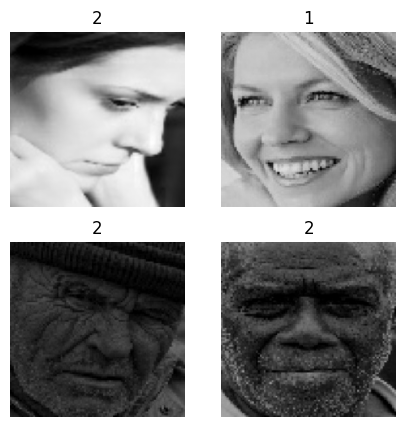

In [90]:
plt.figure(figsize=[5,5])

for i, (image, label) in enumerate(records_dataset.take(4)):
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.title(label.numpy())
    plt.axis("off")

plt.show()
